## Import libraries

In [28]:
main_folder_path = '../../../'

In [33]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Transform google open buildings's geometry
from shapely import wkt

# Correlation calc
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(main_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [3]:
city = 'Merida'
projected_crs = 'EPSG:32616' #Mérida

## Create area of interest

In [10]:
# Load city's hex res 8
hex_schema = 'hexgrid'
hex_table = 'hexgrid_8_city_2020'
hex_type = 'urban'

hex_query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE \"city\" LIKE \'{city}\' AND \"type\" LIKE \'{hex_type}\'"
hex_gdf = aup.gdf_from_query(hex_query, geometry_col='geometry')

# Show
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

EPSG:4326
(718, 6)


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
0,8845098099fffff,"POLYGON ((-89.45301 20.81926, -89.44854 20.821...",31002,Acanceh,Merida,urban
1,88450980d9fffff,"POLYGON ((-89.45762 20.7967, -89.45316 20.7992...",31002,Acanceh,Merida,urban


EPSG:4326
(1, 6)


<Axes: >

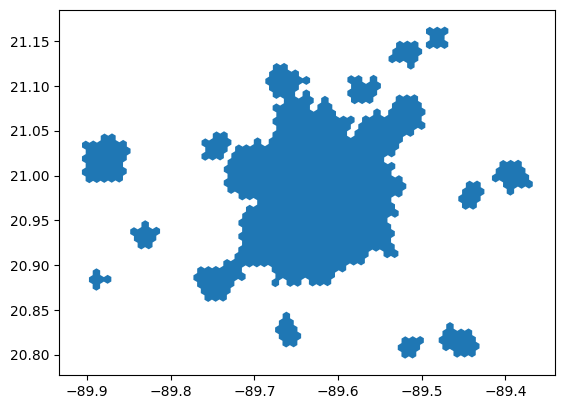

In [11]:
aoi = hex_gdf.dissolve()

# Show
print(aoi.crs)
print(aoi.shape)
aoi.plot()

## Find all blocks within reach of area of interest

In [19]:
# Create a list from a list with all unique cvegeo_mun ('CVE_ENT'+'CVE_MUN') of current city
cvegeo_mun_lst = list(hex_gdf.CVEGEO.unique())

# Load city municipality's blocks
blocks_schema = 'marco'
blocks_table = 'mza_2020'

blocks_gdf = gpd.GeoDataFrame()
for cvegeo_mun in cvegeo_mun_lst:
    
    blocks_query = f"SELECT * FROM {blocks_schema}.{blocks_table} WHERE \"CVEGEO\" LIKE \'{cvegeo_mun}%\'"
    mun_blocks_gdf = aup.gdf_from_query(blocks_query, geometry_col='geometry')
    blocks_gdf = pd.concat([blocks_gdf,mun_blocks_gdf])
    
# Show
print(blocks_gdf.crs)
print(blocks_gdf.shape)
blocks_gdf.head(2)

EPSG:4326
(23145, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,3100200110053013,31,002,0011,0053,013,Rural,Típica,"POLYGON ((-89.44142 20.88801, -89.43981 20.887..."
1,3100200020053013,31,002,0002,0053,013,Rural,Típica,"POLYGON ((-89.42898 20.86323, -89.42907 20.863..."


In [26]:
# Keep blocks that touch the area of interest
aoi_union = aoi.union_all()  # Create shapely object
blocks_aoi_gdf = blocks_gdf[blocks_gdf.intersects(aoi_union)].copy()

# Show
print(blocks_aoi_gdf.crs)
print(blocks_aoi_gdf.shape)
blocks_aoi_gdf.head(2)

EPSG:4326
(21277, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
2,3100200010091007,31,002,0001,0091,007,Urbana,Típica,"POLYGON ((-89.45058 20.8127, -89.4505 20.81268..."
5,3100200010034025,31,002,0001,0034,025,Urbana,Típica,"POLYGON ((-89.45444 20.81015, -89.45383 20.809..."


<Axes: >

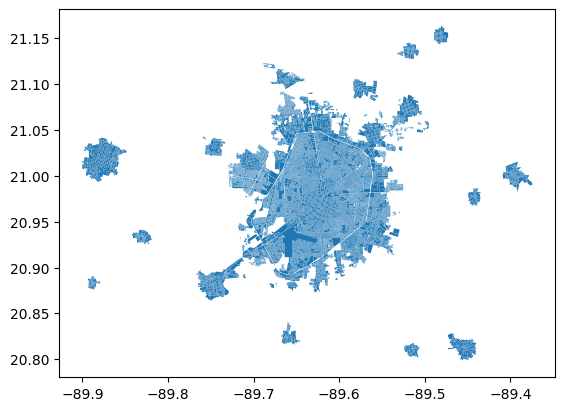

In [27]:
blocks_aoi_gdf.plot()

## Load google buildings

In [36]:
# Load csv
buildings_df = pd.read_csv(main_folder_path+'data/external/google_open_buildings/8f5_buildings.csv')
# Turn into GeoDataFrame
buildings_df['geometry'] = buildings_df['geometry'].apply(wkt.loads)
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry='geometry', crs='EPSG:4326')
del buildings_df

# Show
print(buildings_gdf.crs)
print(buildings_gdf.shape)
buildings_gdf.head(2)

EPSG:4326
(3244124, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,20.913590,-89.743828,71.6770,0.7033,"POLYGON ((-89.74381 20.91354, -89.74378 20.913...",76GGW774+CFMG
1,21.150262,-88.165895,20.3107,0.6709,"POLYGON ((-88.16587 21.15028, -88.1659 21.1502...",76HH5R2M+4J5F


## Keep google buildings within reach of blocks located within area of interest

In [39]:
# Spatial join between buildings and blocks
buildings_aoi_gdf = gpd.sjoin(buildings_gdf, blocks_aoi_gdf, how='inner', predicate='intersects')
# Drop extra cols
buildings_aoi_gdf = buildings_aoi_gdf.drop(columns=['index_right'])

# Show
print(buildings_aoi_gdf.crs)
print(buildings_aoi_gdf.shape)
buildings_aoi_gdf.head(2)

EPSG:4326
(987761, 14)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
7,21.023225,-89.879738,19.8499,0.8195,"POLYGON ((-89.87971 21.02324, -89.87975 21.023...",76HG24FC+74JV,310380001008A022,31,038,0001,008A,022,Urbana,Típica
10,20.916671,-89.624195,13.1274,0.6835,"POLYGON ((-89.62418 20.91665, -89.62418 20.916...",76GGW98G+M87X,3105000015121016,31,050,0001,5121,016,Urbana,Típica
